In [1]:
import qutip as Q
import numpy as np
import matplotlib.pyplot as plt
import itertools
import me_func_defs as mf

This notebook provides an example on how to use the accompanied functions in the file me_func_defs.py to compute dynamics of quantum systems coupled to bosonic environments in the open quantum systems master equation formalism. Especially, here we show how to reproduce the results of the paper [Marco Cattaneo *et al* 2019 *New J. Phys* **21** 113045](https://iopscience.iop.org/article/10.1088/1367-2630/ab54ac), where global and local master equations under the full and partial secular approximation were compared.

## The model Hamiltonian and the environment
The paper studies a quantum system comprised of two qubits interacting with each other and with two local and one common bath in the most general situation. The Hamiltonian of the qubit-qubit system is given by
$$H_\text{S} = \frac{1}{2}\omega_1\sigma_z^{(1)} + \frac{1}{2}\omega_2\sigma_z^{(2)} + \lambda\sigma_x^{(1)}\sigma_x^{(2)}\,,$$
where $\omega_1$ and $\omega_2$ are the qubit frequencies and $\lambda$ is a coupling constant.

The system is in general coupled to three baths. Each qubit has its own local bath, with Hamiltonians $H_\text{B}^{(l_1)}$ and $H_\text{B}^{(l_2)}$, to which it is coupled via $\sigma_x$ and $\sigma_z$ interactions. Additionally the qubits are together coupled to a single common bath with Hamiltonian $H_\text{B}^{(c)}$. The interaction Hamiltonian of the system to the baths is given by
$$H_\text{I} = \left(g_x^{(l_1)}\sigma_x^{(1)} + g_z^{(l_1)}\sigma_z^{(1)}\right)B^{(l_1)} + \left(g_x^{(l_2)}\sigma_x^{(2)} + g_z^{(l_2)}\sigma_z^{(2)}\right)B^{(l_2)}
 + \left(g_x^{(c_1)}\sigma_x^{(1)} + g_x^{(c_2)}\sigma_x^{(2)} + g_z^{(c_1)}\sigma_z^{(1)} + g_z^{
(c_2)}\sigma_z^{(2)}\right)B^{(c)}\,.$$
The coefficients $g_i^j$ are the dimensionless coupling constants that describe the coupling of the system operators to the given bath operators. For example, $g_x^{(l_1)}$ describes the coupling of the system operator $\sigma_x^{(1)}$ to its local bath $l_1$ and similarly for the other coefficients.

This model in mind, we define the operators using predefined QuTiP functions.

In [2]:
#--------------------Building needed operators----------------------
sigma_z = -Q.sigmaz()
sigma_z1 = Q.tensor(sigma_z, Q.identity(2))
sigma_z2 = Q.tensor(Q.identity(2), sigma_z)
sigma_x1 = Q.tensor(Q.sigmax(), Q.identity(2))
sigma_x2 = Q.tensor(Q.identity(2), Q.sigmax())
#-------------------------------------------------------------------

Then we define the system parameters and write the system Hamiltonian (and its local form by neglecting the interaction term) using the operators defined above:

In [3]:
#----------System parameters for the qubit-qubit system-------------
omega_1 = 1
omega_2 = 0.99
lambd = 0
#-------------------------------------------------------------------

#----------Defining the system Hamiltonian-----------------
H_S = (1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
        + lambd*sigma_x1*sigma_x2)
H_S_loc = 1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
#----------------------------------------------------------

Next we define the baths that couple to the system. Each bath is implemented as a separate dictionary, with three distinc key-value pairs:
1. **Key "cpl-ops"** stands for the coupling operators of the system that couple to the bath operators $B^{(j)}$ in the interaction Hamiltonian $H_\text{I}$. These are given as a list, where each element is a different coupling operator in the sum. The coupling operator can also be given directly as a list with one element, where the single element describes the whole sum of the coupling operators.
2. **Key "params"** stands for the bath parameters, which are given as a list. The first element in the list is the temperature $T$ of the bath, second element is the coupling $\alpha$ and third the coefficient $\chi$ that appears in the definition of the spectral density, which quantifies the strength of the coupling of each mode of the environment to the system.
3. **Key "spectral_dens_func"** can take as a value a user defined spectral density function of the bath. The function should take three arguments, $J(\omega, \chi, \omega_c)$, where $\omega$ is frequency, $\chi$ a parameter quantifying the strength of the spectral density and $\omega_c$ some cut-off frequency parameter, which brings the spectral density to zero for $\omega >> \omega_c$ to avoid UV-catastrophe. This key can take also the value 'None' or be left out altogether, in which cases the predefined Ohmic spectral density function with Drude cutoff is used.

In [4]:
#Own definition of the spectral density function
def J(omega, khi, omega_c):
    return khi * omega/(1 + omega**2/omega_c**2)

#------------------Bath parameters------------------
g_x_l1 = 1; g_z_l1 = 1
g_x_l2 = 1; g_z_l2 = 1
g_x_c1 = 1; g_x_c2 = 1
g_z_c1 = 0; g_z_c2 = 0

T_l1 = 1; T_l2 = 10; T_c = 1

alpha_l1 = 0.01; alpha_l2 = 0.01; alpha_c = 0.01
khi_l1 = 1; khi_l2 = 1; khi_c = 1
#---------------------------------------------------

#-------------------Defining the baths---------------------
bath_l1 = {"cpl_ops":[g_x_l1*sigma_x1 + g_z_l1*sigma_z1],
            "params":[T_l1, alpha_l1, khi_l1],
            "spectral_dens_func":J}
bath_l2 = {"cpl_ops":[g_x_l2*sigma_x2 + g_z_l2*sigma_z2],
            "params":[T_l2, alpha_l2, khi_l2],
            "spectral_dens_func":J}
bath_c = {"cpl_ops":[g_x_c1*sigma_x1 + g_x_c2*sigma_x2
                    + g_z_c1*sigma_z1 + g_z_c2*sigma_z2],
            "params":[T_c, alpha_c, khi_c],
            "spectral_dens_func":J}
#----------------------------------------------------------

## The Liouvillian of the master equation
Having defined the system Hamiltonian and the baths, we can now compute the Liouvillian, which is the generator of the dynamics of our open quantum system. We start by writing the master equation in the Redfield form, which is obtained via the standard microscopic derivation by assuming weak coupling between the system and its environment and by applying the Born and Markov approximations. The Redfield master equation reads
$$\frac{d}{d t}\rho_\text{S}(t) = -i\left[H_\text{S} + H_\text{LS}, \rho_\text{S}(t)\right] + \alpha^2\mathcal{D}[\rho_\text{S}(t)]\,,$$
where the dissipator is given by
$$\mathcal{D}[\rho_\text{S}(t)] = \sum_{\beta, \beta^\prime}\sum_{\omega, \omega^\prime}\gamma_{\beta\beta^\prime}(\omega, \omega^\prime)\bigg(A_{\beta^\prime}(\omega)\rho_\text{S}(t)A^\dagger_\beta(\omega^\prime) - \frac{1}{2}\left\{A^\dagger_{\beta}(\omega^\prime)A_{\beta^\prime}(\omega), \rho_\text{S}(t)\right\}\bigg)\,.$$
As usual, $H_\text{LS}$ is the Lamb-shift Hamiltonian which renormalizes the system's eigenenergies due to interaction with the environment, $\beta,\beta^\prime$ are indices that run over the terms in the system-environment interaction Hamiltonian $H_\text{I}$, $\omega, \omega^\prime$ are Bohr frequencies and $A_\beta(\omega)$ are the system jump operators. The factor $\gamma_{\beta,\beta^\prime}(\omega,\omega^\prime)$ describes the coupling to the environment.

The differential equation above can be solved in general form as
$$\rho_\text{S}(t) = e^{\mathcal{L}t}\rho_\text{S}(0)\,,$$
where $\mathcal{L}$ is the Liouvillian superoperator, written in tensor product notation as
$$\mathcal{L} = -i\left(H\otimes\mathbb{1} - \mathbb{1}\otimes H^T\right) + \alpha^2\sum_{\beta,\beta^\prime}\sum_{\omega,\omega^\prime}\gamma_{\beta\beta^\prime}(\omega, \omega^\prime)\bigg(A_{\beta^\prime}(\omega)\otimes A_\beta^*(\omega^\prime) - \frac{1}{2}\left\{\!\!\left\{A_\beta^\dagger(\omega^\prime)A_{\beta^\prime}(\omega)\,,\mathbb{1}\right\}\!\!\right\}\bigg)\,,$$
where we used the superanticommutator defined as
$$\left\{\!\!\left\{X, Y\right\}\!\!\right\} = X\otimes Y^T + Y\otimes X^T\,.$$
Our numerical computation of the open quantum system dynamics computes precisely this Liouvillian $\mathcal{L}$, while taking into account the partial secular approximation as described in the accompanied paper.

The function Liouvillian_general takes the following arguments:
1. The system Hamiltonian.
2. Baths as a list of the different baths the system is coupled to.
3. **Optional** The local Hamiltonian. If this is provided, then the jump operators are computed according to this while the system Hamiltonian is used in the final version of the Liouvillian in the unitary part. Default is 'None'.
4. **Optional** Include Lamb-shift, telling whether to include the Lamb-shift contribution to the final form of the Liouvillian. Default is 'True'.
5. **Optional** Unified_eq, whether to compute the partial secular approximation using the unified equation approach, detailed in the accompanied paper. Default is 'False'.
6. **Optional** Cluster width for the unified equation approach. Default is 0.1.
7. **Optional** plot_clusters, whether to plot the clusters that the unified equation algorithm uses to perform the partial secular approximation. Default is 'False'.
8. **Optional** Psa_cut to determine the cut off value for the partial secular approximation. Default is 10000.
9. **Optional** Tolerance within which two numbers are treated the same. Default is 1e-10.
10. **Optional** Cut off frequency $\omega_c$ that is supplied to the spectral density function. Default is 100.
11. **Optional** Whether to print more detailed information when the algorithm is running. Default is 'False'.

Below we compute two Liouvillians: one in the case where the partial secular approximation is applied (with psa_cut=1e4) and one where the full secular approximation is done (psa_cut = 0).

In [5]:
#----------------Computing the Liouvillian-------------------
psa_cut = 1e4
baths = [bath_c]
L_PSA = mf.Liouvillian_general(H_S, baths, psa_cut=1e4, omega_c=20)[0]
L_FSA = mf.Liouvillian_general(H_S, baths, psa_cut=0, omega_c=20)[0]
#------------------------------------------------------------


Bath 1:
...Jumps computed in 0.02s


/u/25/vaarana3/data/Documents/PhD/Koodit/PSA-general/me_func_defs.py:216: RuntimeWarning: overflow encountered in double_scalars
  BE = 1/(np.e**(omega_norm*C) - 1)


...LS computed in 0.48s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.79s

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s


## Computing the dynamics
Next we define the initial state of the system to be the superposition state for both qubits and compute the time evolution of the system.

In [6]:
#---------------Defining the initial state---------------
q1_0 = 1/np.sqrt(2)*(Q.basis(2, 0) + Q.basis(2,1))
q2_0 = 1/np.sqrt(2)*(Q.basis(2, 0) + Q.basis(2,1))

psi_0 = Q.tensor(q1_0, q2_0)
rho_0 = psi_0*psi_0.dag()
#--------------------------------------------------------

#----------------Computing the time evolution------------------
t = np.linspace(0, 5000, num=1000)
proj_exc = Q.tensor(Q.ket('e')*Q.bra('e'), Q.identity(2))
res_PSA = mf.evolution([proj_exc], rho_0, t, L_PSA)[0]
res_FSA = mf.evolution([proj_exc], rho_0, t, L_FSA)[0]
#--------------------------------------------------------------


Computing evolution:
|████████████████████████████████████████| 1000/1000 [100%] in 7.0s (141.56/s)  

Computing evolution:
|████████████████████████████████████████| 1000/1000 [100%] in 4.6s (218.05/s)  


Then we plot the data to reveal Fig. 2b of the reference.

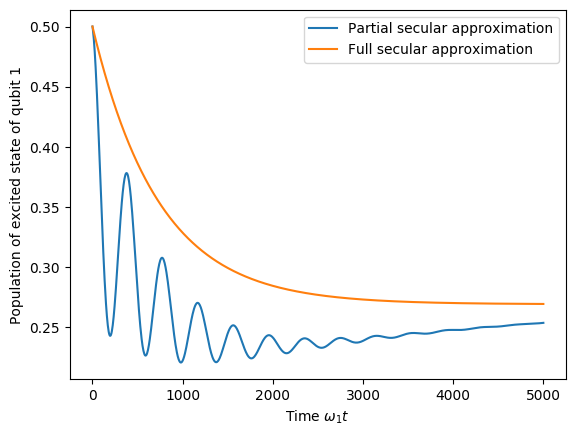

In [7]:
plt.plot(t, res_PSA, label="Partial secular approximation")
plt.plot(t, res_FSA, label="Full secular approximation")
plt.legend()
plt.xlabel("Time $\omega_1 t$")
plt.ylabel("Population of excited state of qubit 1")
plt.show(block=False)

## Other figures

Next we change the system parameters and add coupling to the local baths only to plot Fig. 3a.


Bath 1:
...Jumps computed in 0.02s
...LS computed in 0.78s
...Out of 78 jump operator pairs 41 were discarded due to secular approximation
...Dissipator computed in 0.80s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.63s
...Out of 78 jump operator pairs 41 were discarded due to secular approximation
...Dissipator computed in 0.70s

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.32s
...Out of 78 jump operator pairs 62 were discarded due to secular approximation
...Dissipator computed in 0.35s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.28s
...Out of 78 jump operator pairs 62 were discarded due to secular approximation
...Dissipator computed in 0.31s

Computing evolution:
|████████████████████████████████████████| 1000/1000 [100%] in 4.3s (232.16/s)  

Computing evolution:
|████████████████████████████████████████| 1000/1000 [100%] in 4.2s (236.80/s)  


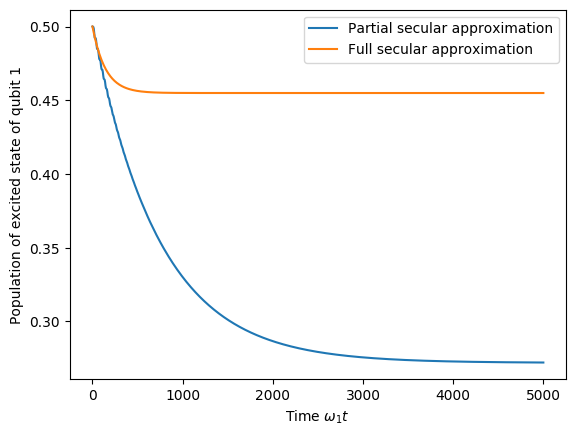

In [8]:
#----------System parameters for the qubit-qubit system-------------
omega_1 = 1
omega_2 = 1
lambd = 1e-4
#-------------------------------------------------------------------

#----------Defining the system Hamiltonian-----------------
H_S = (1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
        + lambd*sigma_x1*sigma_x2)
H_S_loc = 1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
#----------------------------------------------------------

#----------------Computing the Liouvillian-------------------
psa_cut = 1e4
baths = [bath_l1, bath_l2]
L_PSA = mf.Liouvillian_general(H_S, baths, psa_cut=1e4, omega_c=20)[0]
L_FSA = mf.Liouvillian_general(H_S, baths, psa_cut=0, omega_c=20)[0]
#------------------------------------------------------------

res_PSA = mf.evolution([proj_exc], rho_0, t, L_PSA)[0]
res_FSA = mf.evolution([proj_exc], rho_0, t, L_FSA)[0]

plt.plot(t, res_PSA, label="Partial secular approximation")
plt.plot(t, res_FSA, label="Full secular approximation")
plt.legend()
plt.xlabel("Time $\omega_1 t$")
plt.ylabel("Population of excited state of qubit 1")
plt.show(block=False)

And then to produce Fig. 5c, we disconnect the local baths and switch on the common one with strong qubit-qubit interaction. Here we also compare the predictions of local and global master equations.


Bath 1:
...Jumps computed in 0.05s
...LS computed in 0.55s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.36s

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.27s

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.42s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Computing evolution:
|████████████████████████████████████████| 10000/10000 [100%] in 47.1s (212.11/s

Computing evolution:
|████████████████████████████████████████| 10000/10000 [100%] in 48.6s (205.63/s

Computing evolution:
|████████████████████████████████████████| 10000/10000 [100%] in 48.2s (208.00/s

Co

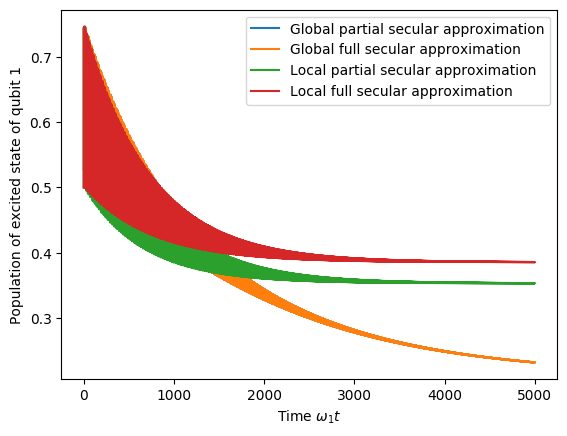

In [9]:
#----------System parameters for the qubit-qubit system-------------
omega_1 = 1
omega_2 = 0.99
lambd = 1
#-------------------------------------------------------------------

#----------Defining the system Hamiltonian-----------------
H_S = (1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
        + lambd*sigma_x1*sigma_x2)
H_S_loc = 1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2
#----------------------------------------------------------

#----------------Computing the Liouvillian-------------------
psa_cut = 1e4
baths = [bath_c]
L_PSA = mf.Liouvillian_general(H_S, baths, psa_cut=1e4, omega_c=20)[0]
L_FSA = mf.Liouvillian_general(H_S, baths, psa_cut=0, omega_c=20)[0]
L_PSA_loc = mf.Liouvillian_general(H_S, baths, local_Hamiltonian=H_S_loc, psa_cut=1e4, omega_c=20)[0]
L_FSA_loc = mf.Liouvillian_general(H_S, baths, local_Hamiltonian=H_S_loc, psa_cut=0, omega_c=20)[0]
#------------------------------------------------------------

t = np.linspace(0, 5000, num=10000)
res_PSA = mf.evolution([proj_exc], rho_0, t, L_PSA)[0]
res_FSA = mf.evolution([proj_exc], rho_0, t, L_FSA)[0]
res_PSA_loc = mf.evolution([proj_exc], rho_0, t, L_PSA_loc)[0]
res_FSA_loc = mf.evolution([proj_exc], rho_0, t, L_FSA_loc)[0]

plt.plot(t, res_PSA, label="Global partial secular approximation")
plt.plot(t, res_FSA, label="Global full secular approximation")
plt.plot(t, res_PSA_loc, label="Local partial secular approximation")
plt.plot(t, res_FSA_loc, label="Local full secular approximation")
plt.legend()
plt.xlabel("Time $\omega_1 t$")
plt.ylabel("Population of excited state of qubit 1")
plt.show(block=False)

## Heat flow
Next we consider the steady state heat flow through the system by coupling the qubits to the two separate baths on either side and setting a temperature difference between them. Then the steady state of the system $\rho_\infty$ is computed as the eigenstate of the Liouvillian superoperator corresponding to the zero eigenvalue. The steady state heat flow is then obtained by computing
$$J = \text{Tr}[H_\text{S}\mathcal{D}[\rho_\infty]]$$
where $\mathcal{D}[\cdot]$ is the dissipator of the warmer bath.

With this example we compare the local and global master equations together with the full and partial secular approximation. The implementation for reproducing Fig. 7a from the provided reference is shown below:

In [10]:
#-----------Defining the used parameters-------------
omega_1 = 1; omega_2 = 0.999
#----------------------------------------------------

#-----------Updated bath parameters-----------
g_x_l1 = 1; g_z_l1 = 0
g_x_l2 = 1; g_z_l2 = 0

T_l1 = 1; T_l2 = 10

alpha_l1 = 0.01; alpha_l2 = 0.01
khi_l1 = 1; khi_l2 = 1
#---------------------------------------------

def J(omega, khi, omega_c):
    return khi * omega/(1 + omega**2/omega_c**2)

#-------------------Updating the baths---------------------
bath_l1 = {"cpl_ops":[g_x_l1*sigma_x1 + g_z_l1*sigma_z1],
            "params":[T_l1, alpha_l1, khi_l1],
            "spectral_dens_func":J}
bath_l2 = {"cpl_ops":[g_x_l2*sigma_x2 + g_z_l2*sigma_z2],
            "params":[T_l2, alpha_l2, khi_l2],
            "spectral_dens_func":J}
bath_c = {"cpl_ops":[g_x_c1*sigma_x1 + g_x_c2*sigma_x2
                    + g_z_c1*sigma_z1 + g_z_c2*sigma_z2],
            "params":[T_c, alpha_c, khi_c],
            "spectral_dens_func":J}
#----------------------------------------------------------

#Creating a list of couplings
lambdas = np.logspace(-6, 3, num=100)

#Creating lists for the heat flows
Js_local = []
Js_global_FSA = []
Js_global_PSA = []

for i in [0,1,2]:
    #-------Computing the heat flow for each lambda-------
    for lambd in lambdas:
        print("\nComputing lambda {}".format(lambd))
        H_S = 1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2 + lambd*sigma_x1*sigma_x2
        H_S_loc = 1/2*omega_1*sigma_z1 + 1/2*omega_2*sigma_z2

        if(i==0):
            L, u, disslist = mf.Liouvillian_general(H_S, 
                                                    [bath_l1, bath_l2], 
                                                    local_Hamiltonian=H_S_loc,
                                                    psa_cut=0, 
                                                    omega_c=20)
        if(i==1):
            L, u, disslist = mf.Liouvillian_general(H_S, 
                                                    [bath_l1, bath_l2],
                                                    psa_cut=0, 
                                                    omega_c=20)
        if(i==2):
            L, u, disslist = mf.Liouvillian_general(H_S, 
                                                    [bath_l1, bath_l2],
                                                    psa_cut=1e4, 
                                                    omega_c=20)
        dissipator = disslist[1]
        
        #Computing the index of eigenvalue zero of Liouvillian
        #by checking the absmin of all eigenvalues
        min_idx = np.argmin(np.abs(L.eigenstates()[0]))
        
        #The steady state is the operator version of the found 
        #eigenvector. It is also normalized to unit trace
        rho_f = mf.vec_to_op(L.eigenstates()[1][min_idx])
        rho_f = rho_f/rho_f.tr()
            
        #Computing the heat flow
        diss_rho = mf.vec_to_op(dissipator * mf.op_to_vec(rho_f))
        J = (H_S*diss_rho).tr()
        
        if(i==0):
            Js_local.append(J)
        if(i==1):
            Js_global_FSA.append(J)
        if(i==2):
            Js_global_PSA.append(J)
    #--------------------------------------------------------


Computing lambda 1e-06

Bath 1:
...Jumps computed in 0.02s
...LS computed in 0.14s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.16s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 1.232846739442066e-06

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 1.519911082952933e-06

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.15s

Bath 2:
...Jumps computed in 0.01s
...LS

...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Computing lambda 0.0001

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 0.0001232846739442066

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.14s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.13s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Computing lambda 0.0001519911082952933

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.13s
...Out of 10 jump operator pairs 4 were 

...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 0.01

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 0.012328467394420659

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...D

...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Computing lambda 1.0

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.13s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.12s

Computing lambda 1.232846739442066

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.13s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.11s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissi

...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Computing lambda 100.0

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.14s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.13s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.13s

Computing lambda 123.28467394420684

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.14s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Dissipator computed in 0.15s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.12s
...Out of 10 jump operator pairs 4 were discarded due to secular approximation
...Di

...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.29s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Computing lambda 8.111308307896873e-06

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.27s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.24s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.26s

Computing lambda 1e-05

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.30s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded d

...LS computed in 0.22s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.24s

Computing lambda 0.0006579332246575682

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.24s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Computing lambda 0.0008111308307896872

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.29s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.24s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.24s

Computing lambda 0.001

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36

...LS computed in 0.28s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.29s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.98s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.55s

Computing lambda 0.06579332246575682

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.27s

Bath 2:
...Jumps computed in 0.02s
...LS computed in 1.36s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.29s

Computing lambda 0.08111308307896872

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.97s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 1.44s

Bath 2:
...Jumps computed in 0.04s
...LS computed in 1.17s
...Out of 36 jump operator pairs 24 were

...LS computed in 0.27s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.23s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Computing lambda 6.5793322465756825

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.28s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.24s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Computing lambda 8.111308307896872

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.27s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.27s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.23s
...Out of 36 jump operator pairs 24 were di

...LS computed in 0.23s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.22s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.24s

Computing lambda 657.9332246575682

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.26s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.22s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.27s

Computing lambda 811.130830789689

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.23s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.25s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.22s
...Out of 36 jump operator pairs 24 were disc

...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.41s

Computing lambda 4.328761281083062e-05

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.42s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.48s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.41s

Computing lambda 5.3366992312063123e-05

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.42s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.43s

Computing lambda 6.579332246575683e-05

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.46s
...Out of 36 jump o

...LS computed in 0.43s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.42s

Computing lambda 0.004328761281083062

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.42s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.41s

Computing lambda 0.005336699231206312

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.42s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 we

...LS computed in 0.43s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.42s

Computing lambda 0.43287612810830617

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.43s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.46s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.38s
...Out of 36 jump operator pairs 16 were discarded due to secular approximation
...Dissipator computed in 0.42s

Computing lambda 0.5336699231206312

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.25s
...Out of 36 jump operator pairs 24 were discarded due to secular approximation
...Dissipator computed in 0.27s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.23s
...Out of 36 jump operator pairs 24 were 

...LS computed in 0.31s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.34s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.28s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.31s

Computing lambda 43.287612810830616

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.31s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.34s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.29s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.31s

Computing lambda 53.366992312063125

Bath 1:
...Jumps computed in 0.01s
...LS computed in 0.31s
...Out of 36 jump operator pairs 20 were discarded due to secular approximation
...Dissipator computed in 0.33s

Bath 2:
...Jumps computed in 0.01s
...LS computed in 0.28s
...Out of 36 jump operator pairs 20 were d

/u/25/vaarana3/unix/myEnv_Py3.8.10/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


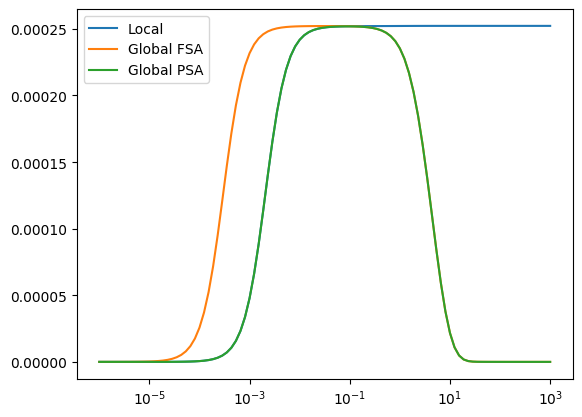

In [11]:
plt.plot(lambdas, Js_local, label="Local")
plt.plot(lambdas, Js_global_FSA, label="Global FSA")
plt.plot(lambdas, Js_global_PSA, label="Global PSA")
plt.xscale('log')
plt.legend()
plt.show()